training input data shape:  (60000, 28, 28)
training output data shape:  (60000,)
test data shape:  (10000, 28, 28)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_80 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_81 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
training output data shape (one-hot-encoded):  (60000, 10)


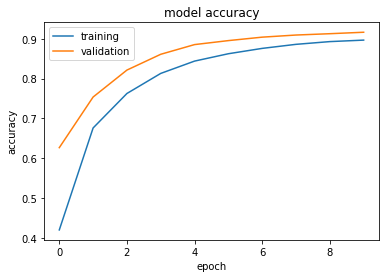

Test loss:  0.44491461968421936
Test accuracy:  0.9069


In [45]:
# Based on this article:
# https://medium.com/tebs-lab/how-to-classify-mnist-digits-with-different-neural-network-architectures-39c75a0f03e3

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
import matplotlib.pyplot as plt

from keras.utils.vis_utils import plot_model

# For tensorboard:
import numpy as np
from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
# end for tensorboard

class SGDOptimizer:
    def __init__(self, params):
        self.method = keras.optimizers.SGD
        self.params = params
        
    def instance(self):
        return self.method(lr=self.params.learning_rate, momentum=self.params.momentum, 
                           decay=self.params.decay, nesterov=False)

    
class Optimizer:
    def __init__(self, params):
        self.optimizers = {
            "sgd" : SGDOptimizer
        }
        self.optimizer_id = params.optimizer
        self.params = params
    
    def instance(self):
        return self.optimizers[self.optimizer_id](self.params).instance()
        
        
class ModelFactory:
    def __init__(self, params):
        self.params = params
        
        # Training hyperparameters
        self.decay = params.decay
        self.learning_rate = params.learning_rate
        self.momentum = params.momentum
        self.optimizer = params.optimizer
        self.loss_function = params.loss_function
        self.epochs = params.epochs
        self.batch_size = params.batch_size
        # Activation function to be applied to hidden layers.
        self.activation_function = params.activation_function

        # Network structure related hyperparameters
        # Number of hidden layers
        self.depth = params.depth
        # Number of neurons in each hidden layer
        self.widths = np.copy(params.widths)
        self.weight_init_strategy = params.weight_init_strategy
        # A regularization method used with larger networks
        #self.dropouts

        self.load_data()

    def load_data(self):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()

        print("training input data shape: ", self.x_train.shape)
        print("training output data shape: ", self.y_train.shape)
        print("test data shape: ", self.x_test.shape)

        
    def build_model(self):
        self.model = Sequential()

        # At every layer's neuron: output = activation(dot(input, weight_input) + bias)
        # Input layer is implicit.
        # Hence, input_shape for this layer becomes 28*28.

        # Hidden layers
        for layer in range(self.depth):
            self.model.add(Dense(units=self.widths[layer], activation=self.activation_function,
                                 input_shape=(image_size,),
                                 kernel_initializer=self.weight_init_strategy))


        num_classes = 10
        # Output layer: 10 neurons, one neuron for each place within the one-hot-vector.
        # Interesting: Softmax takes the output of all 10 neurons and distributes them into probabilities.
        # If we had applied Sigmoid for instance, then it'd apply sigmoid to each neuron separately.
        # See this (for a picture) https://sebastianraschka.com/faq/docs/softmax_regression.html
        self.model.add(Dense(units=num_classes, activation='softmax',
                             kernel_initializer=self.weight_init_strategy))

        self.model.summary()

        optimizer = Optimizer(self.params)
        self.model.compile(optimizer=optimizer.instance(), loss=self.loss_function, metrics=['accuracy'])

    def train(self):
        # Flatten the image
        image_size = 28 * 28
        self.x_train = self.x_train.reshape(self.x_train.shape[0], image_size)
        self.x_test = self.x_test.reshape(self.x_test.shape[0], image_size)

        num_classes = 10
        self.y_train = keras.utils.to_categorical(self.y_train, num_classes)
        self.y_test = keras.utils.to_categorical(self.y_test, num_classes)

        print("training output data shape (one-hot-encoded): ", y_train.shape)

        # Training
        self.history = self.model.fit(self.x_train, self.y_train, batch_size=self.batch_size, 
                                      epochs=self.epochs, 
                                      verbose=False, validation_split=.1)
                                

    def validate(self):
        # Testing
        self.loss, self.accuracy  = self.model.evaluate(self.x_test, self.y_test, verbose=False)

    def plot_stats(self):
        plt.plot(self.history.history['acc'])
        plt.plot(self.history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['training', 'validation'], loc='best')
        plt.show()

        print('Test loss: ', self.loss)
        print('Test accuracy: ', self.accuracy)


class NetworkParams:
    def __init__(self):
        self.weight_init_strategy = "glorot_uniform"
        self.depth = 2
        self.widths = []
        for layer in range(self.depth):
            self.widths.append(64)

        self.activation_function = "sigmoid"        
        self.epochs = 10
        self.batch_size = 128
    
        self.optimizer = "sgd"
        self.loss_function = "categorical_crossentropy"
        self.decay = 0.0
        self.momentum = 0.0
        self.learning_rate = 0.01

        
params = NetworkParams()
mnistFactory = ModelFactory(params)
mnistFactory.build_model()
mnistFactory.train()
mnistFactory.validate()
mnistFactory.plot_stats()
# Uncomment the below to generate a plot.png from keras utils.
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Uncomment the below line to show the tensorboard.
# show_graph(tf.get_default_graph().as_graph_def())



In [2]:
# Custom softmax function
# Note: Softmax always takes an array of input, and outputs an array of probability distibs.
# If input has a single number, then output would also have a single 1.0. 
logits = [2.0, 1.0, 0.1]
import numpy as np
exps = [np.exp(i) for i in logits]
sum_of_exps = sum(exps)
softmax = [j/sum_of_exps for j in exps]
for v in softmax:
    print(v)

0.6590011388859679
0.2424329707047139
0.09856589040931818
